# [10] 객체 검출하기

모델의 학습이 끝났다면 이제 실제 이미지를 모델에 입력해서 객체 검출(Object Detection)을 잘 수행할 수 있는지를 확인해 보도록 하겠습니다. 먼저, 아래의 코드를 실행하여 출력값을 살펴봄으로써 이전 실습까지의 과정을 복습해 봅시다.


In [1]:
import torch
from torch.utils.data.dataloader import DataLoader
from materials.DetectionNet import DetectionNet, create_prior_boxes
from materials.datasets import PascalVOCDataset
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = PascalVOCDataset(data_folder='./data/VOC', split='TRAIN')
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, collate_fn=train_dataset.collate_fn)
images, boxes, labels, difficulties = next(iter(train_dataloader))

images = images.to(device)
boxes = [b.to(device) for b in boxes]
labels = [l.to(device) for l in labels]

print('\nImage Batch Shape: {}'.format(images.shape))
print('Boxes Batch Length: {}'.format(len(boxes)))
print('Labels Batch Length: {}'.format(len(labels)))

net = DetectionNet(n_classes=20, unfreeze_keys=['15', 'head', 'bn1'], use_bias=True).to(device)
net.load_state_dict(torch.load('./test_199_1.378.pth'), strict=False)
net.eval()
pred_locs, pred_scores = net(images)

print('\n>>> Location 예측의 Shape: {}'.format(pred_locs.shape))
print('>>> Clsss Score 예측의 Shape: {}'.format(pred_scores.shape))

prior_boxes = create_prior_boxes()
print('\n>>> Prior Boxes의 Shape: {}'.format(prior_boxes.shape))


Image Batch Shape: torch.Size([16, 3, 300, 300])
Boxes Batch Length: 16
Labels Batch Length: 16
Loaded pretrained weights for efficientnet-b0

>>> Location 예측의 Shape: torch.Size([16, 3106, 4])
>>> Clsss Score 예측의 Shape: torch.Size([16, 3106, 20])

>>> Prior Boxes의 Shape: torch.Size([3106, 4])


In [2]:
from IPython.display import HTML, display

# Image from https://robocademy.com
display(HTML("<img src='img/[10]nms.png'>"))

-------------------
## [Task 1] Non-Maximum Suppression
Object Detection을 위해 예측된 box와 label에 대해서 Non-Maximum Suppression을 수행해 보도록 하겠습니다.

### ToDo: `detect_objects` 함수 완성하기

함수를 완성하여 NMS를 구현해 봅시다.

In [3]:
import torch
import torch.nn.functional as F
from materials.utils import *


def detect_objects(predicted_locs, predicted_scores, priors_cxcy, min_score, max_overlap, top_k, n_classes=20):
    """
    각 Class의 min_score 이상의 class score를 가지는 box들에 대해 Non-Maximum Suppression(NMS)를 수행합니다.
    
    max_overlap : 각 box들이 서로 최대 이 값 만큼만 겹칠 수 있습니다. 이 값을 넘어가면 lower score box부터 suppress됩니다.
    top_k : Detection 실행 후 최대 몇 개의 box를 남길 것인지를 결정합니다.
    """
    batch_size = predicted_locs.size(0)
    n_priors = priors_cxcy.size(0)
    
    # class score를 확률값으로 바꾸어 줍니다. (총합이 1, class별로 0~1의 값)
    predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 3106, n_classes)

    # 최종 예측 결과를 저장할 list를 만듭니다.
    all_images_boxes, all_images_labels, all_images_scores = [], [], []

    assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)
    
    # Batch 안의 각 Image마다
    for i in range(batch_size):
        # (x0, y0, x1, y1)의 좌표값으로 바꿉니다.
        decoded_locs = cxcy_to_xy(
            gcxgcy_to_cxcy(predicted_locs[i], priors_cxcy))  # (3106, 4)

        # 현재 image에 대한 최종 예측을 저장할 list를 만듭니다.
        image_boxes, image_labels, image_scores = [], [], []
        
        # [ToDo]: 각 Box가 가지는 Class Score의 최댓값과 라벨을 구합니다.
        max_scores, best_label = ??????????.???(??????)  # (3106)

        # 각 Class에 대해서
        for c in range(1, n_classes):
            # min_score 이상의 값을 가지는 prediction인지의 여부를 판별합니다.
            class_scores = predicted_scores[i][:, c]  # (3106)
            score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, 인덱싱을 하기 위함
            
            # min_score를 넘는 prediction의 개수를 구합니다.
            n_above_min_score = score_above_min_score.sum().item()
            
            # min_score를 넘는 prediction이 없으면 다음 이미지에 대한 연산으로 넘어갑니다.
            if n_above_min_score == 0:
                continue

            # min_score 이상의 값을 가지는 box들만을 남깁니다.
            class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 3106
            class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

            # 걸러진 box들을 Score에 따라 정렬합니다.
            class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
            class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

            # 걸러진 box들 사이의 overlap된 정도를 측정합니다.
            overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

            # Non-Maximum Suppression (NMS) 을 수행합니다.
            # 1 은 suppress(제거할), 0 은 suppress하지 않는(제거하지 않는) box를 나타냅니다.
            suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

            # Score가 큰 순서대로 box에 대한 연산을 다음과 같이 합니다.
            for box in range(class_decoded_locs.size(0)):
                # [ToDo]: 만약 box가 이미 suppress되었다면 다음 box에 대한 연산으로 넘어갑니다.
                if suppress[?????] == ????:
                    continue

                # maximum overlap보다 더 큰 overlap을 가지는 box를 찾아 suppres index를 업데이트합니다.
                suppress = torch.max(suppress, (overlap[box] > max_overlap).byte())

                # [ToDo]: 현재 보고 있는 box는 어떠한 경우에도 suppress하지 않습니다. (max_overlap=1으로 항상 계산됨)
                suppress[????] = ??????????

            # 현재 class에 대해 unsuppressed box만 저장합니다.
            image_boxes.append(class_decoded_locs[1 - suppress])
            image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
            image_scores.append(class_scores[1 - suppress])

        # object가 발견되지 않았을 경우의 placeholder
        if len(image_boxes) == 0:
            image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
            image_labels.append(torch.LongTensor([0]).to(device))
            image_scores.append(torch.FloatTensor([0.]).to(device))

        # [ToDo]: 결과값을 하나의 tensor로 만듭니다.
        image_boxes = torch.cat(??????????, dim=?)  # (n_objects, 4)
        image_labels = torch.cat(?????????, dim=?)  # (n_objects)
        image_scores = torch.cat(?????????, dim=?)  # (n_objects)
        n_objects = image_scores.size(0)

        # 최대 top_k개의 obeject만 결과로 저장합니다.
        if n_objects > top_k:
            image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
            image_scores = image_scores[:top_k]  # (top_k)
            image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
            image_labels = image_labels[sort_ind][:top_k]  # (top_k)

        # 최종 결과 list에 저장합니다.
        all_images_boxes.append(image_boxes)
        all_images_labels.append(image_labels)
        all_images_scores.append(image_scores)

    return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

-------------------
## [Task 2] Object Detection 수행하기
이미지를 받아서 예측하고, NMS를 수행한 다음 최종 Bounding Box들이 표현된 이미지를 출력하는 과정까지를 하나의 함수로 완성해 봅시다.

In [4]:
from torchvision import transforms
from materials.utils import *
from PIL import Image, ImageDraw, ImageFont


# Model에 입력하기 위한 기본 Transformation을 설정합니다.
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, model, min_score=0.5, max_overlap=0.3, top_k=5, suppress=None):
    # [ToDo]: model을 test mode로 설정합니다.
    model.???????
    
    # Transform을 수행합니다.
    image = normalize(to_tensor(resize(original_image)))

    # 지정된 device에서 연산합니다.
    image = image.to(device)

    # model에 대한 forward pass를 연산합니다.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
    prior_boxes = ????????????????????
    priors_cxcy = xy_to_cxcy(prior_boxes)
    
    # [ToDo]: detection 결과를 연산합니다.
    det_boxes, det_labels, det_scores = detect_objects(?????????????, ????????????????, ???????????, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k, n_classes=20)

    # 결과값을 cpu에 저장합니다.
    det_boxes = det_boxes[0].to('cpu')

    # 원래의 image 크기로 변환합니다.
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # 라벨 값(0~20)에 대응하는 라벨 이름을 가져옵니다.
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]
    
    # background 뿐이면 이미지를 그대로 출력합니다.
    if det_labels == ['background']:
        return original_image

    # 이미지 위에 bounding box와 라벨을 표시합니다.
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()
    
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])
        
        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image

-------------------
## [Task 3] 결과 확인하기

테스트해볼 이미지를 골라 결과를 확인해 봅시다.

In [6]:
with open('./data/VOC/TRAIN_images.json', 'r') as j:
    train_images = json.load(j)
    
with open('./data/VOC/TEST_images.json', 'r') as j:
    test_images = json.load(j)
    
print(test_images[:10])

['/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000001.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000002.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000003.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000004.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000006.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000008.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000010.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000011.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000013.jpg', '/home/gihun/jupyter/LG_project/Lecture/data/VOC/VOCdevkit/VOC2007/JPEGImages/000014.jpg']


Loaded pretrained weights for efficientnet-b0


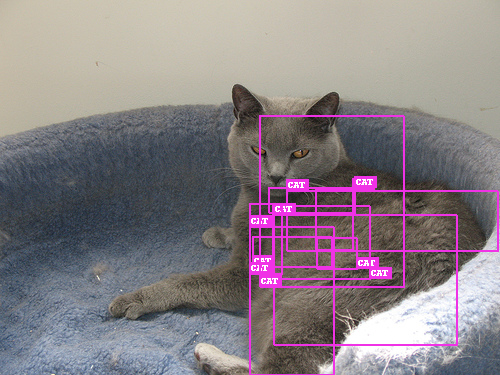

In [7]:
#img_path = test_images[1500]
img_path = train_images[12500]
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
import warnings
warnings.filterwarnings("ignore")

net = DetectionNet(n_classes=20, unfreeze_keys=['15', 'head', 'bn1'], use_bias=True).to(device)
net.load_state_dict(torch.load('./40epoch_39_2.381.pth'), strict=False)
net.eval()

annotated_image = detect(original_image, net, min_score=0.5, max_overlap=0.3, top_k=10, suppress=None)
annotated_image

---------
### <생각해 봅시다>

- 여러 이미지에 대해서 학습 결과를 관찰해 봅시다. 학습이 잘 되었나요?
    - 잘 되지 않은 부분이 있다먼 어째서일까요?
    

- 학습을 얼마나 잘했는지를 어떻게 수치화할 수 있을까요?

- 탐지 과정에서 사용된 HyperParameter들은 각각 어떤 의미를 가지고 있나요?
------------